In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [18]:
def get_gray_img(img_path):
    img = cv2.imread('./test_images/test1.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [19]:
def crop_img(img, keep_below=350):
    return img[keep_below:,:]

/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


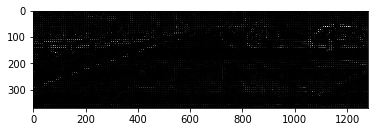

In [24]:
import cv2
gray = get_gray_img('./test_images/test1.jpg')
cropped = crop_img(gray)
features, hog_image = get_hog_features(cropped, 9, 8, 2, vis=True)
plt.imshow(hog_image, cmap='gray')